In [1]:
import pandas as pd
import seaborn as sns
from geopy.distance import geodesic

In [2]:
df = pd.read_csv('nyc_taxi_hw.csv')

# Considerations

Acording to `https://www.nyc.gov/site/tlc/passengers/taxi-fare.page`, fares have a $3 base, depends slighty on time (surcharge at night and rush hours):

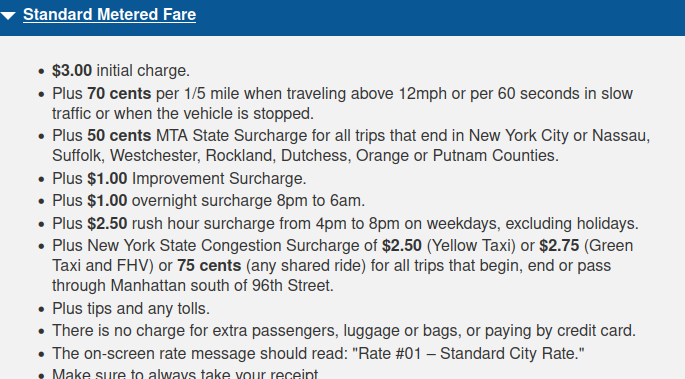

And most notably, drives to the airport are considerably expensier: 

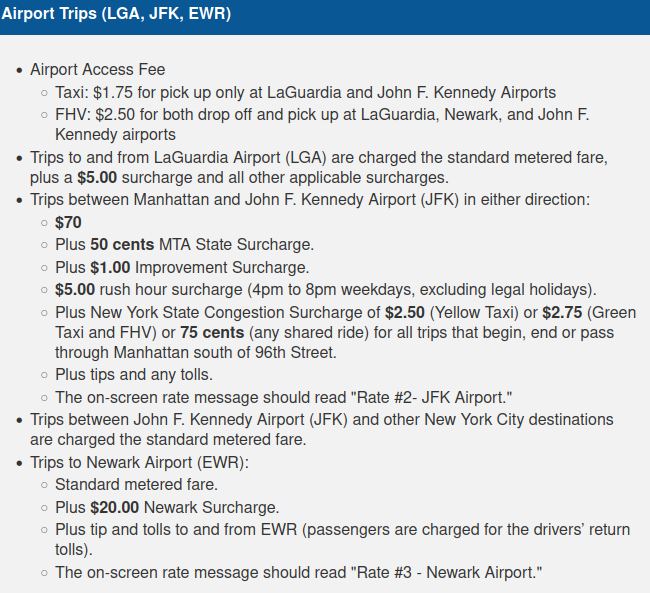

Therefore, there might be some `seemingly strange` fares compared to distance when traveling to and from the airports

# Data cleansing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         100000 non-null  int64  
 1   key                100000 non-null  object 
 2   fare_amount        100000 non-null  float64
 3   pickup_datetime    100000 non-null  object 
 4   pickup_longitude   100000 non-null  float64
 5   pickup_latitude    100000 non-null  float64
 6   dropoff_longitude  100000 non-null  float64
 7   dropoff_latitude   100000 non-null  float64
 8   passenger_count    100000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 6.9+ MB


In [4]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['key'] = pd.to_datetime(df['key'])

# Localizing the time to New York (UTC-4)
df['key'] = df['key'].dt.tz_localize('UTC').dt.tz_convert('America/New_York')
df['pickup_datetime'] = df['pickup_datetime'].dt.tz_convert('America/New_York')

In [6]:
# See if key and pickup_datetime are the same
count = 0
for i, key in enumerate(df['key']):
    if pd.Timedelta(key - df['pickup_datetime'][i]) > pd.Timedelta('1s'):
        count += 1

print(count)

0


In [7]:
# as key and pickup_datetime are the same, we can drop key
# we also drop Unnamed: 0 since it is just an index
df = df.drop(columns=['key'])
df = df.drop(columns=['Unnamed: 0'])

In [8]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 13:26:21-04:00,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 11:52:16-05:00,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-17 20:35:00-04:00,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 00:30:42-04:00,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 02:51:00-05:00,-73.968095,40.768008,-73.956655,40.783762,1


## Outliers

In [9]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


### fare_amount

Expensive fares might be possible, so we only delete negative and below 3 (minimum in NY) fares

In [10]:
# count fare_amount < 0
df[df['fare_amount'] <= 3]['fare_amount'].count()

847

In [11]:
# drop fares that are less than 0
df = df[df['fare_amount'] > 0]

### passenger_count

Negative or zero passengers are not possible

In [12]:
# count passenger_count < 1
df[df['passenger_count'] < 1]['passenger_count'].count()

366

In [13]:
# drop passenger_count < 1
df = df[df['passenger_count'] >= 1]

### pickup and dropoff

We will get the mayority of 'normal' latitudes by droping values at the edges of the distribution (using z-score)

In [14]:
outliers_df = pd.DataFrame(columns=df.columns)

for column in ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']:
    # Calculate the mean and standard deviation for the column
    mean = df[column].mean()
    std_dev = df[column].std()
    
    # Calculate the z-score for each value in the column
    z_scores = (df[column] - mean) / std_dev
    
    # Identify outliers
    outliers = ((z_scores < -2.5) | (z_scores > 2.5))
    outliers_df = pd.concat([outliers_df, df[outliers]])

outliers_df = outliers_df.drop_duplicates()


/tmp/ipykernel_306775/1354899925.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outliers_df = pd.concat([outliers_df, df[outliers]])


In [15]:
outliers_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
11,5.5,2012-12-24 06:24:00-05:00,0.0,0.0,0.0,0.0,3
15,5.0,2013-11-23 07:57:00-05:00,0.0,0.0,0.0,0.0,1
26,6.5,2011-02-07 15:01:00-05:00,0.0,0.0,0.0,0.0,1
124,8.0,2013-01-17 12:22:00-05:00,0.0,0.0,0.0,0.0,2
192,3.7,2010-09-05 13:08:00-04:00,0.0,0.0,0.0,0.0,5


In [16]:
outliers_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000
mean,11.877469,-2.667554,0.456055,-2.579530,0.676163
std,10.893293,23.021698,16.666907,16.961258,16.939289
min,2.500000,-736.550000,-74.007670,-84.654241,-74.006377
25%,5.725000,0.000000,0.000000,0.000000,0.000000
50%,8.500000,0.000000,0.000000,0.000000,0.000000
75%,13.300000,0.000000,0.000000,0.000000,0.000000
max,128.830000,40.787575,401.083332,40.851027,404.616667


In [17]:
print('outliers % =' ,len(outliers_df) / len(df) * 100)

outliers % = 2.077854289213226


In [18]:
# Since 2% is considered as outliers, we can remove them. Also note that they are mostly zeros
# this will not affect models since otherwise we would have and unbalanced dataset (98 k normal vs 2 k outliers)
df_cleaned = df.drop(outliers_df.index)
df_cleaned.to_csv('nyc_taxi_hw_cleaned.csv', index=False)

In [19]:
df_cleaned.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97552.000000,97552.000000,97552.000000,97552.000000,97552.000000,97552.000000
mean,11.353995,-73.975183,40.751031,-73.974017,40.751465,1.680365
std,9.698173,0.045685,0.036181,0.039903,0.037160,1.298522
min,0.010000,-78.083332,38.754215,-75.354559,39.296307,1.000000
25%,6.000000,-73.992266,40.736640,-73.991395,40.735761,1.000000
50%,8.500000,-73.982076,40.753531,-73.980437,40.753962,1.000000
75%,12.500000,-73.968287,40.767678,-73.965127,40.768476,2.000000
max,200.000000,-70.140793,43.183332,-72.854940,43.415190,6.000000


## Data analysis

## Distance

We use geodesic since the points are on a sphere not on a plane

In [20]:
df_cleaned['distance'] = df_cleaned.apply(lambda x: geodesic((x['pickup_latitude'], x['pickup_longitude']), (x['dropoff_latitude'], x['dropoff_longitude'])).kilometers, axis=1)

In [21]:
df_cleaned.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,4.5,2009-06-15 13:26:21-04:00,-73.844311,40.721319,-73.841610,40.712278,1,1.029601
1,16.9,2010-01-05 11:52:16-05:00,-74.016048,40.711303,-73.979268,40.782004,1,8.443441
2,5.7,2011-08-17 20:35:00-04:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389132
3,7.7,2012-04-21 00:30:42-04:00,-73.987130,40.733143,-73.991567,40.758092,1,2.795790
4,5.3,2010-03-09 02:51:00-05:00,-73.968095,40.768008,-73.956655,40.783762,1,1.998338


In [22]:
# show in desc by distance
df_cleaned.sort_values(by='fare_amount', ascending=False).head(15)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
28373,200.00,2012-02-25 22:24:00-05:00,-73.954922,41.391042,-73.954918,41.391042,1,0.000335
1335,180.00,2013-01-16 15:19:58-05:00,-74.429332,40.500046,-74.429332,40.500046,1,0.000000
43956,165.00,2014-10-31 23:35:37-04:00,-73.931776,40.754153,-73.919801,40.797735,1,4.944216
1483,165.00,2009-08-07 17:49:13-04:00,-73.633363,41.032490,-73.633671,41.032598,1,0.028543
61163,160.77,2015-03-03 11:34:57-05:00,-73.866600,40.771149,-73.816216,41.092316,1,35.917975
46198,160.00,2013-05-13 07:18:00-04:00,-73.644528,41.009100,-73.641208,41.021182,1,1.370511
62648,160.00,2013-04-11 23:16:58-04:00,-73.963953,40.706716,-73.964433,40.707917,1,0.139401
91906,150.00,2011-08-08 08:48:00-04:00,-74.184730,40.564767,-74.184730,40.564767,1,0.000000
78623,150.00,2014-06-18 17:05:35-04:00,-73.993463,40.751660,-74.474595,40.797252,1,40.932082
26027,149.00,2014-08-14 16:22:14-04:00,-73.855030,40.729882,-73.855039,40.729884,4,0.000792


Strangelly, some rides with high fares have distances of 0 km, this might be: 

- an error on the latitude and longitudes of those rows (een so 1.5% of data might not affect models)
- maybe taxists started and finished rides on the destination becoause of an error on payment, or client decided to add a tip, etc

In [23]:
df_cleaned[df_cleaned['distance'] < 0.03].count()

fare_amount          1429
pickup_datetime      1429
pickup_longitude     1429
pickup_latitude      1429
dropoff_longitude    1429
dropoff_latitude     1429
passenger_count      1429
distance             1429
dtype: int64

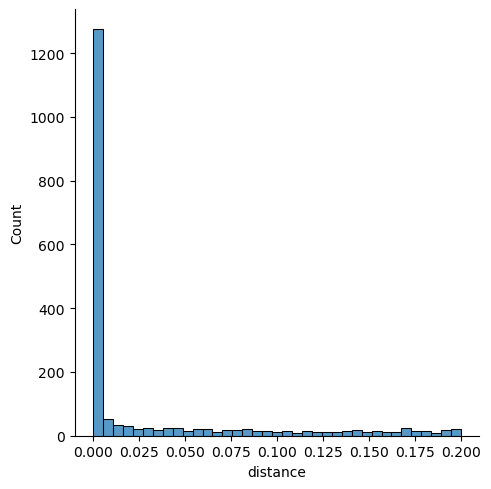

In [24]:
sns.displot(df_cleaned[df_cleaned['distance'] < 0.2]['distance'])

<Axes: xlabel='distance', ylabel='fare_amount'>

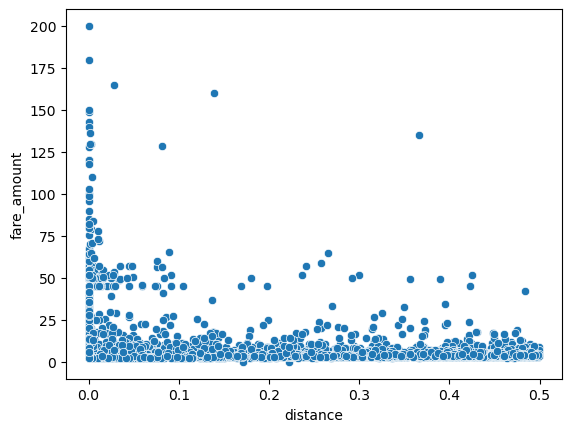

In [25]:
sns.scatterplot(data = df_cleaned[df_cleaned['distance'] < 0.5], x='distance', y='fare_amount')

## Date and time

In [26]:
# make a categorical variable for the day of the week
df_cleaned['day_of_week'] = df_cleaned['pickup_datetime'].dt.day_name()
df_cleaned['day_of_week'] = pd.Categorical(df_cleaned['day_of_week'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], ordered=True) # reorder the days

# make a categorical variable for the hour of the day
df_cleaned['hour_of_day'] = df_cleaned['pickup_datetime'].dt.hour

# make a categorical variable for the month of the year
df_cleaned['month_of_year'] = df_cleaned['pickup_datetime'].dt.month_name()
df_cleaned['month_of_year'] = pd.Categorical(df_cleaned['month_of_year'], categories=['January','February','March','April','May','June','July','August','September','October','November','December'], ordered=True) # reorder the months

#overnight
df_cleaned['overnight'] = df_cleaned['hour_of_day'].apply(lambda x: 1 if (x < 6 or x >= 20) else 0) # refer to the link above

# rush hour
df_cleaned['rush_hour'] = df_cleaned['hour_of_day'].apply(lambda x: 1 if (x >= 16 and x < 20) else 0) # refer to the link above

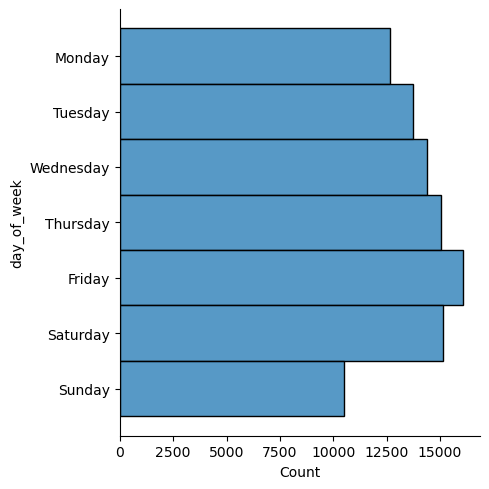

In [27]:
sns.displot(data = df_cleaned, y='day_of_week')

A lot of people don't take taxis on sundays or don't go out

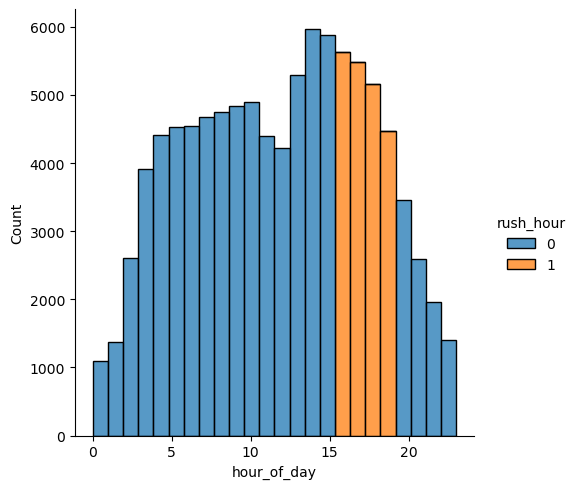

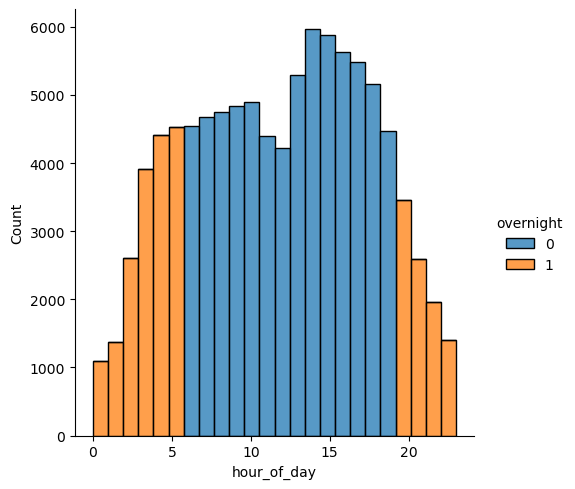

In [28]:
sns.displot(data=df_cleaned, x='hour_of_day', bins=24, hue='rush_hour', multiple='stack')
sns.displot(data=df_cleaned, x='hour_of_day', bins=24, hue='overnight', multiple='stack')


There are peaks at lunch starting rush hours

<Axes: xlabel='fare_amount', ylabel='day_of_week'>

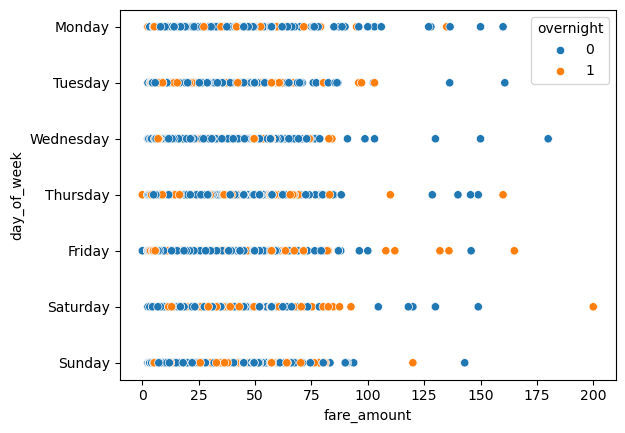

In [29]:
sns.scatterplot(data = df_cleaned, y='day_of_week', x='fare_amount', hue='overnight')

<Axes: xlabel='fare_amount', ylabel='day_of_week'>

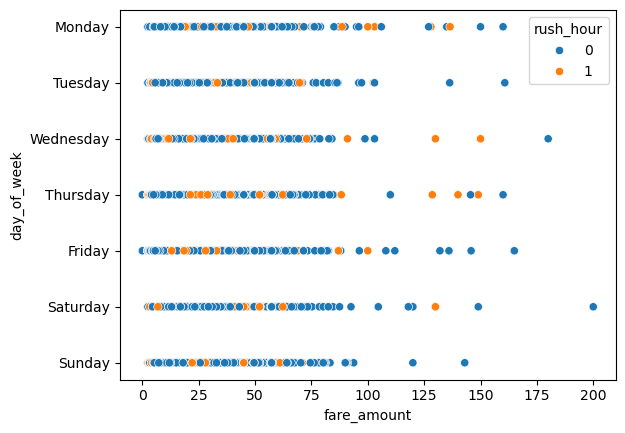

In [30]:
sns.scatterplot(data = df_cleaned, y='day_of_week', x='fare_amount', hue='rush_hour')

Expensive fares not seem to be mostly on rush hours or overnight drives

<Axes: xlabel='day_of_week', ylabel='fare_amount'>

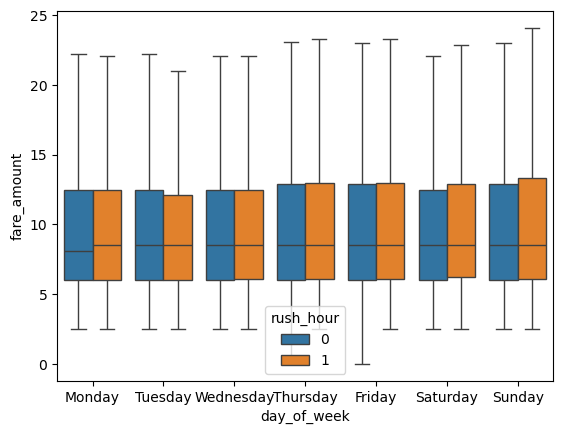

In [31]:
sns.boxplot(data = df_cleaned, x='day_of_week', y='fare_amount', showfliers=False, hue='rush_hour')

Fare prices do not really vary on weekdays

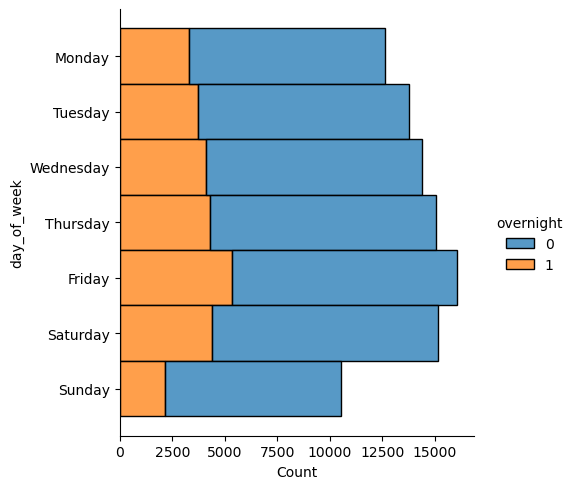

In [32]:
sns.displot(data = df_cleaned, y='day_of_week', hue='overnight', multiple='stack')


There's a peak of overnight drives on Friday and drives

## Location

In [33]:
# from https://www.travelmath.com/airport/EWR
LGA = (40.7747222222, -73.8719444444) # LaGuardia Airport ($5 extra)
JFK = (40.6441666667, -73.7822222222) # John F. Kennedy International Airport ($70 extra)
EWR = (40.6897222222, -74.1744444444) # Newark Liberty International Airport ($20 extra)

In [34]:
df_cleaned['near_LGA'] = df_cleaned.apply(lambda x: 1 if geodesic((x['pickup_latitude'], x['pickup_longitude']), LGA).kilometers < 1 or geodesic((x['dropoff_latitude'], x['dropoff_longitude']), LGA).kilometers < 1 else 0, axis=1)
df_cleaned['near_JFK'] = df_cleaned.apply(lambda x: 1 if geodesic((x['pickup_latitude'], x['pickup_longitude']), JFK).kilometers < 1 or geodesic((x['dropoff_latitude'], x['dropoff_longitude']), JFK).kilometers < 1 else 0, axis=1)
df_cleaned['near_EWR'] = df_cleaned.apply(lambda x: 1 if geodesic((x['pickup_latitude'], x['pickup_longitude']), EWR).kilometers < 1 or geodesic((x['dropoff_latitude'], x['dropoff_longitude']), EWR).kilometers < 1 else 0, axis=1)

In [35]:
df_cleaned['airport'] = df_cleaned.apply(lambda x: 'LGA' if x['near_LGA'] == 1 else ('JFK' if x['near_JFK'] == 1 else ('EWR' if x['near_EWR'] == 1 else 'None')), axis=1)

In [36]:
df_cleaned.airport.value_counts()

airport
None    92834
LGA      2604
JFK      1990
EWR       124
Name: count, dtype: int64

Most drives aren't from airports, so most drives should be inexpensive

<Axes: xlabel='airport', ylabel='fare_amount'>

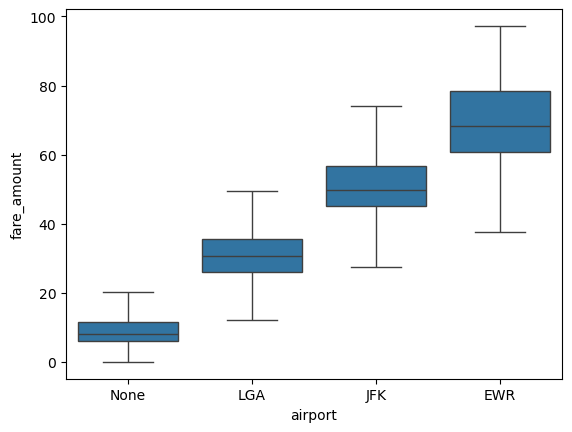

In [37]:
# airport and fare_amount
sns.boxplot(data = df_cleaned, x='airport', y='fare_amount', showfliers=False)

As expected, the fares from or ot any airport is significatively expensier than drives in the city

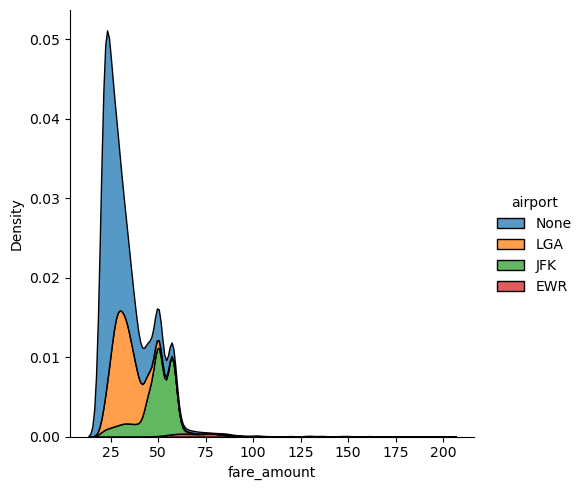

In [38]:
# plot distribution of fares of trips to airports
sns.displot(data = df_cleaned[df_cleaned['fare_amount'] >20], x='fare_amount', hue='airport', multiple='stack', kind='kde')

The distribution of expensive fares is almost identical for drives near JFK, LGA and no None, but normal drives have more density obviously

# Model to predict fares

In [39]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97552 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype                           
---  ------             --------------  -----                           
 0   fare_amount        97552 non-null  float64                         
 1   pickup_datetime    97552 non-null  datetime64[ns, America/New_York]
 2   pickup_longitude   97552 non-null  float64                         
 3   pickup_latitude    97552 non-null  float64                         
 4   dropoff_longitude  97552 non-null  float64                         
 5   dropoff_latitude   97552 non-null  float64                         
 6   passenger_count    97552 non-null  int64                           
 7   distance           97552 non-null  float64                         
 8   day_of_week        97552 non-null  category                        
 9   hour_of_day        97552 non-null  int32                           
 10  month_of_year  

In [40]:
df_cleaned.to_csv('nyc_taxi_hw_cleaned.csv', index=False)

In [42]:
# Data split

from sklearn.model_selection import train_test_split

X = df_cleaned[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'distance', 'day_of_week', 'hour_of_day', 'month_of_year', 'overnight', 'rush_hour', 'airport']]
X = pd.get_dummies(X, drop_first=True)
y = df_cleaned['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# linear regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mean_squared_error(y_test, y_pred)

print('MSE:', mean_squared_error(y_test, y_pred))


MSE: 38.29578737422323


In [44]:
# polynomial characteristics on linear regression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degree = 2 # since the dataset is big, from 3 and up takes too much time
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(X_train, y_train)
y_pred = polyreg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

MSE: 28.075337138078183


In [45]:
# polinomial regression
from sklearn.linear_model import Ridge

degree = 2
polyreg = make_pipeline(PolynomialFeatures(degree), Ridge())
polyreg.fit(X_train, y_train)
y_pred = polyreg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

MSE: 26.07952618428987


In [55]:
# use PCA to reduce the number of features
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model = LinearRegression()
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_test_pca)
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

MSE: 41.303251951560505


In [56]:
# PCA and polynomial regression

degree = 2
polyreg = make_pipeline(PolynomialFeatures(degree), Ridge())
polyreg.fit(X_train_pca, y_train)
y_pred = polyreg.predict(X_test_pca)
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

MSE: 30.17599721553165


In [70]:
# basic neural network

from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(5, 5), max_iter=15, verbose=True, activation='relu', alpha=0.0001, solver='adam', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

Iteration 1, loss = 121.69874145
Iteration 2, loss = 47.80804959
Iteration 3, loss = 44.81750001
Iteration 4, loss = 25.63060700
Iteration 5, loss = 13.36221760
Iteration 6, loss = 12.84682928
Iteration 7, loss = 12.83002671
Iteration 8, loss = 12.84038524
Iteration 9, loss = 12.81620472
Iteration 10, loss = 12.80323445
Iteration 11, loss = 12.80935278
Iteration 12, loss = 12.77335025
Iteration 13, loss = 12.81310753
Iteration 14, loss = 12.78893599
Iteration 15, loss = 12.76963547
MSE: 25.744585576899414


/home/sthefano/miniforge3/envs/cloud/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(


We can see that neural networks are powerful, and even a small network achieved the smallest MSE from all models, so it might be good to make fine tunning on a model to get better results. However, polinomial regression is quite close and uses less resources.